In [85]:
import get_processed_data as gpd
import numpy as np
from tsai.all import *
from sklearn.metrics import accuracy_score

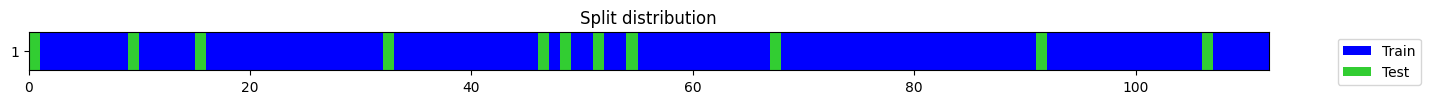

In [86]:
train, test = gpd.get_train_test_split("malte", 10*60, 5*60)

train_easy = train["easy"]
train_hard = train["hard"]

test_easy = test["easy"]
test_hard = test["hard"]

y_train_easy = np.full(len(train_easy), 'easy', dtype=object)
y_train_hard = np.full(len(train_hard), 'hard', dtype=object)
y_test_easy = np.full(len(test_easy), 'easy', dtype=object)
y_test_hard = np.full(len(test_hard), 'hard', dtype=object)

X = np.concatenate([train_easy, train_hard])
y = np.concatenate([y_train_easy, y_train_hard])

X = np.stack([np.transpose(np.array(x[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z']].tolist()), (1, 0)) for x in X])

# create an array with two arrays inside for train and test. the train array contains the indices of the train samples and the test array the indices of the test samples
splits = get_splits(range(len(train_easy) + len(train_hard)), 1, 0.1)

X_test = np.concatenate([test_easy, test_hard])
y_test = np.concatenate([y_test_easy, y_test_hard])
X_test = np.stack([np.transpose(np.array(x[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z', 'FreeAcc_X', 'FreeAcc_Y', 'FreeAcc_Z']].tolist()), (1, 0)) for x in X_test])


epoch,train_loss,valid_loss,accuracy,time
0,0.672237,0.698470,0.454545,00:00
1,0.660756,0.695398,0.454545,00:00
2,0.645967,0.691675,0.545455,00:00
3,0.612005,0.686250,0.727273,00:00
4,0.573669,0.678044,0.818182,00:00
5,0.525967,0.668849,0.818182,00:00
6,0.486328,0.656681,0.818182,00:00
7,0.464980,0.635411,0.818182,00:00
8,0.425959,0.602732,0.818182,00:00
9,0.397445,0.574160,0.818182,00:00


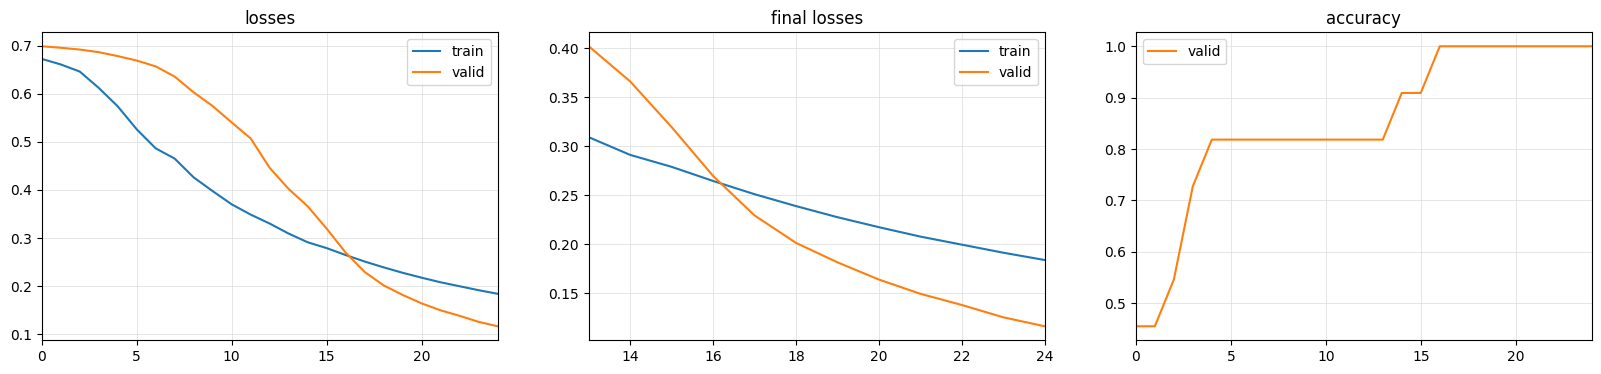

In [87]:
from tsai.all import *

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()


In [88]:
PATH = Path('./models/test.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
# learn.export(PATH)
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')


In [89]:
del learn, dsets, dls

learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid

test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
accuracy_score(test_targets, test_preds)

1.0

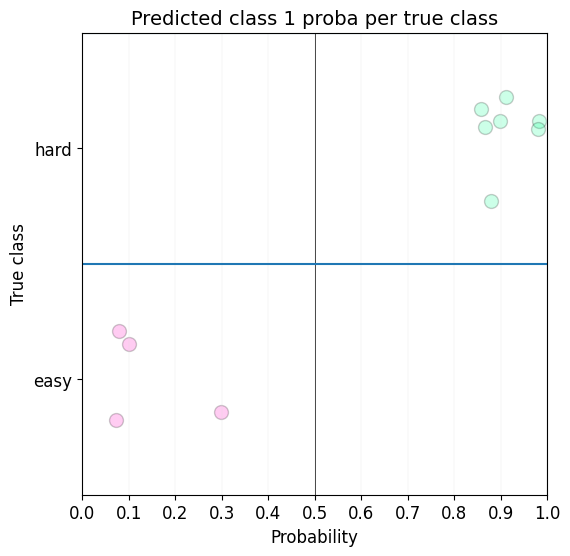

In [94]:

learn.show_probas()

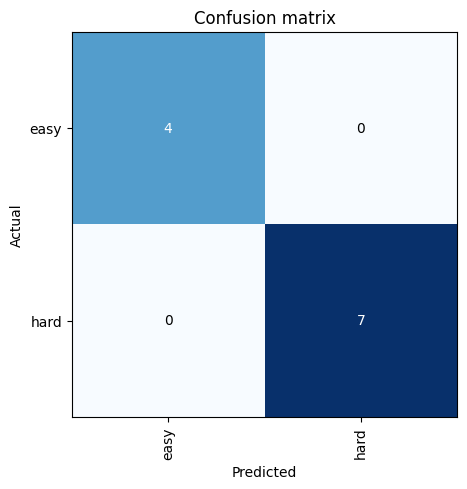

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()